# Attention Is (Almost) All You Need

Before taking DS593, the biggest limitation in my understanding of large language models was attention. I tried reading articles and watching videos to understand this vital concept, but I couldn’t wrap my head around it. However, after going through it in lecture and reading the resources provided by Prof. Wheelock (namely Jay Alammar’s Illustrated Guide to Transformers), the concept is finally clear to me. I therefore wanted to share my newfound understanding and build on the work I did in Lab 3 to create a comprehensive guide to self attention that ends with me actually training the weights I randomly initialized previously!

In the lab I visualized how attention would apply to the sentence "Jane is going to the cinema to watch a new comedy", however, the visuals were purely canonical and the weights had no actual meaning. The goal of this project is to build on those visuals with clear explanations of what is actually going on in each, then to finally train the weights such that we can extract some actual meaning and insights from them.


## Motivation
When we read the sentence "Jane is going to the cinema to watch a new comedy", we easily understand that "she" refers to Jane, that "watch" relates to "cinema" and "comedy", and that "new" modifies "comedy" not "cinema". This kind of contextual reasoning is exactly what the attention mechanism is designed to replicate.

This notebook builds self-attention from scratch, covering:

1. Single-head scaled dot-product attention
2. Why learned projections matter
3. Multi-head attention
4. Training Q/K/V weights


## Setup and Imports

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from transformers import AutoTokenizer

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

print(f'PyTorch version: {torch.__version__}')
print('Setup complete.')

PyTorch version: 2.10.0+cu128
Setup complete.


## Part 1: Tokenization and Embeddings

Before attention can operate, we need to convert raw text into numerical vectors. This involves two steps:

1. Tokenization: splitting text into subword units using a pretrained tokenizer (we use BERT's WordPiece tokenizer)
2. Embedding lookup: mapping each token ID to a learned vector in $\mathbb{R}^{d_{\text{model}}}$

We use $d_{\text{model}} = 32$ which is small enough to be interpretable, large enough to be expressive. In practice this is much larger.

In [2]:
sentence = "Jane is going to the cinema to watch a new comedy"

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
enc = tokenizer(sentence, return_tensors='pt')
token_ids = enc['input_ids'].squeeze(0)
tokens = tokenizer.convert_ids_to_tokens(token_ids)

vocab_size = tokenizer.vocab_size
d_model = 32

embedding_layer = nn.Embedding(vocab_size, d_model)
X = embedding_layer(token_ids)  # shape: (seq_len, d_model)

print(f'Sentence: "{sentence}"')
print(f'Tokens:   {tokens}')
print(f'Token IDs: {token_ids.tolist()}')
print(f'Embedding matrix X shape: {X.shape}  (seq_len={X.shape[0]}, d_model={X.shape[1]})')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Sentence: "Jane is going to the cinema to watch a new comedy"
Tokens:   ['[CLS]', 'jane', 'is', 'going', 'to', 'the', 'cinema', 'to', 'watch', 'a', 'new', 'comedy', '[SEP]']
Token IDs: [101, 4869, 2003, 2183, 2000, 1996, 5988, 2000, 3422, 1037, 2047, 4038, 102]
Embedding matrix X shape: torch.Size([13, 32])  (seq_len=13, d_model=32)


## Part 2: Single-Head Scaled Dot-Product Attention

### The Core Formula

$$\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right) V$$

The intuition is elegant: each token in the sequence asks a **query** ("what am I looking for?"), every token broadcasts a **key** ("what do I contain?"), and the dot product $QK^\top$ measures compatibility. After softmaxing into a probability distribution, these weights are used to take a weighted sum of **values** — what each token actually contributes.

The three projection matrices $W_Q$, $W_K$, $W_V \in \mathbb{R}^{d_{\text{model}} \times d_k}$ are learned and they teach the model which aspects of each token to query, which to advertise as a key, and what information to retrieve as a value.

### Why Divide by $\sqrt{d_k}$?

The dot product $QK^\top$ grows in magnitude with $d_k$. Without scaling, with large $d_k$, the softmax input is so large that gradients vanish (the softmax saturates to near-one-hot distributions). Dividing by $\sqrt{d_k}$ stabilizes the variance of the dot products regardless of dimensionality

In [3]:
# Demonstrating the scaling effect
torch.manual_seed(0)
d_demo = 512
q_demo = torch.randn(d_demo)
k_demo = torch.randn(d_demo)

dot = q_demo @ k_demo
print(f'Without scaling: dot product = {dot.item():.2f}')
print(f'With scaling:    dot product = {(dot / math.sqrt(d_demo)):.2f}')
print(f'Expected std without scaling: ~sqrt(d_k) = {math.sqrt(d_demo):.1f}')
print(f'Expected std with scaling:    ~1.0')

Without scaling: dot product = -35.35
With scaling:    dot product = -1.56
Expected std without scaling: ~sqrt(d_k) = 22.6
Expected std with scaling:    ~1.0


In [4]:
# Single-head attention
torch.manual_seed(42)

W_q = torch.randn(d_model, d_model)
W_k = torch.randn(d_model, d_model)
W_v = torch.randn(d_model, d_model)

Q = X @ W_q   # (seq_len, d_model)
K = X @ W_k
V = X @ W_v

# Compatibility scores
scores = Q @ K.T                        # (seq_len, seq_len)
scaled_scores = scores / math.sqrt(d_model)
attention_weights = torch.softmax(scaled_scores, dim=-1)  # row-wise softmax

# Context vectors
context = attention_weights @ V          # (seq_len, d_model)

print(f'Q shape: {Q.shape}')
print(f'K shape: {K.shape}')
print(f'V shape: {V.shape}')
print(f'Attention weights shape: {attention_weights.shape}')
print(f'Context vectors shape:   {context.shape}')

Q shape: torch.Size([13, 32])
K shape: torch.Size([13, 32])
V shape: torch.Size([13, 32])
Attention weights shape: torch.Size([13, 13])
Context vectors shape:   torch.Size([13, 32])


The attention weight matrix is `(seq_len × seq_len)`. Entry `[i, j]` tells us how much token $i$ attends to token $j$ when constructing its context vector. Each row sums to 1.0, it's a probability distribution over positions.

Note we apply `softmax(dim=-1)` row-wise. This means each query position distributes its attention across all key positions.

In [ ]:
def plot_attention(attn_matrix, tokens, title='Attention Weights', ax=None):
    """Plot a single attention weight matrix as a heatmap."""
    if isinstance(attn_matrix, torch.Tensor):
        attn_matrix = attn_matrix.detach().cpu().numpy()

    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(8, 7))

    sns.heatmap(
        attn_matrix,
        xticklabels=tokens,
        yticklabels=tokens,
        annot=True, fmt='.2f', annot_kws={'size': 7},
        cmap='Blues', vmin=0, vmax=1,
        linewidths=0.5, ax=ax
    )
    ax.set_title(title, fontsize=12, pad=10)
    ax.set_xlabel('Key (attended to)', fontsize=9)
    ax.set_ylabel('Query (attending from)', fontsize=9)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

    if standalone:
        plt.tight_layout()
        plt.show()

plot_attention(attention_weights, tokens, title='Single-Head Attention (Random Weights)')

With randomly initialized weights, the attention pattern has no semantic structure and each token attends roughly uniformly across the sequence. This is expected since the weights $W_Q, W_K, W_V$ haven't learned anything yet. Meaningful patterns will form after training.



## Part 3: Experiment — Why Learned Projections Matter

A natural question that arises at this point is why do we even need $W_Q, W_K, W_V$? What happens if we use the raw embeddings directly as queries, keys, and values — i.e., $Q = K = V = X$?

This is sometimes called "raw" or "identity" attention. Let's compute it and compare.

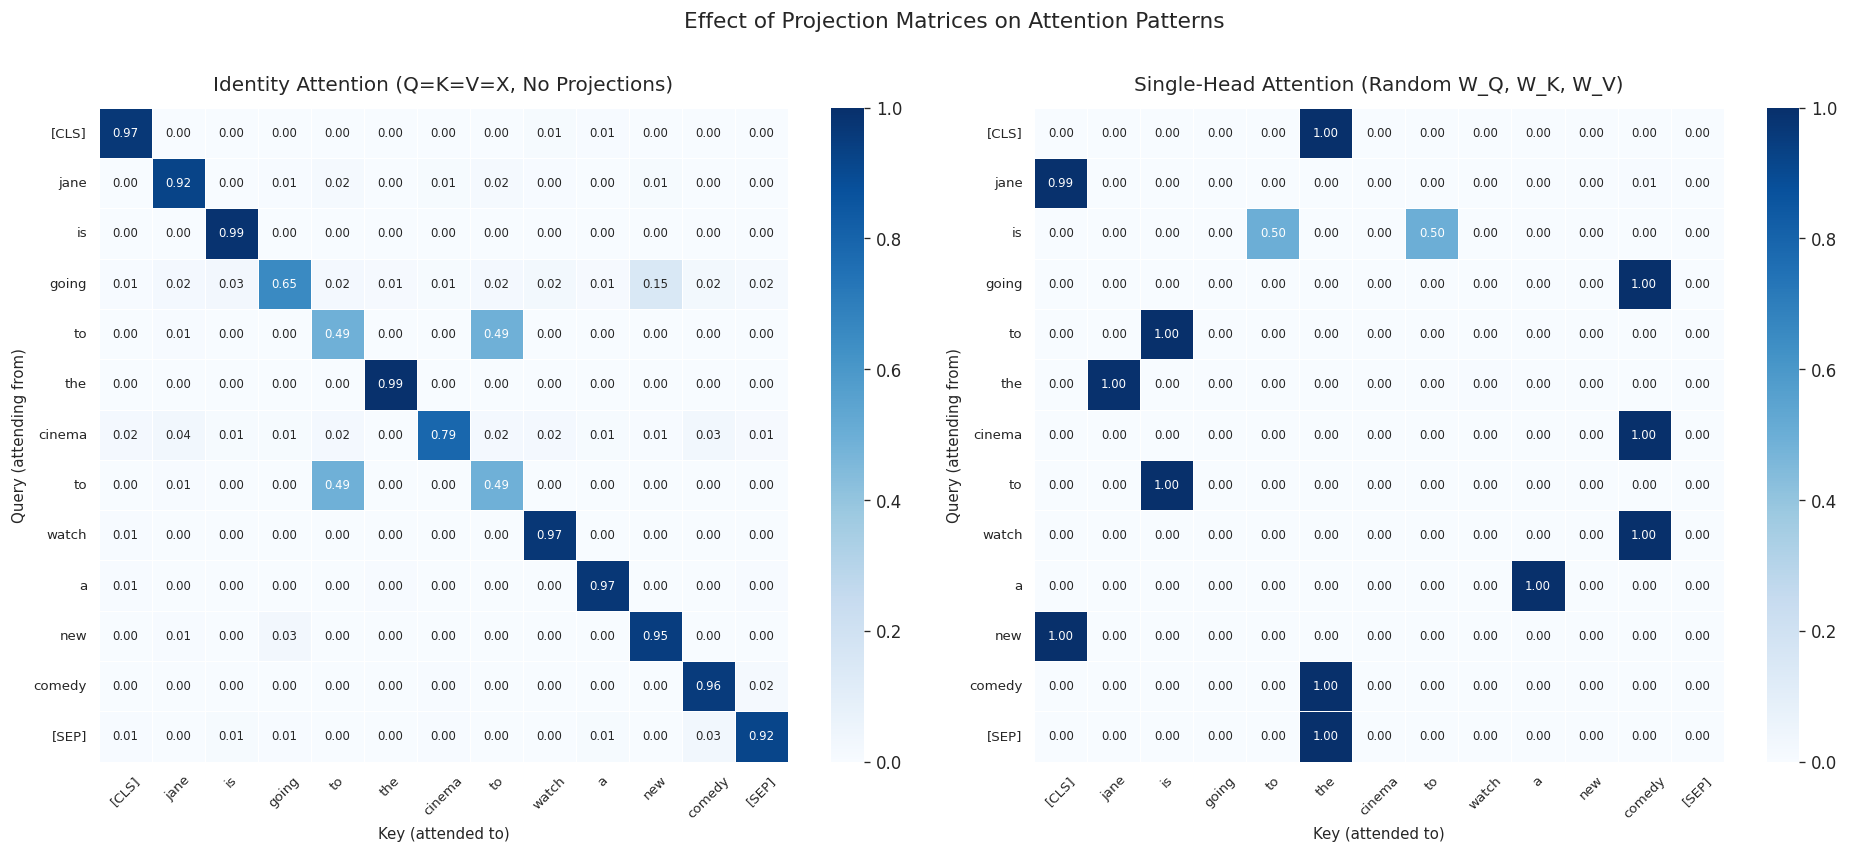

Mean diagonal weight — Identity: 0.8505 | Projected: 0.0770


In [6]:
# Identity attention: Q = K = V = X (no projections)
scores_id = X @ X.T
scaled_id = scores_id / math.sqrt(d_model)
attention_id = torch.softmax(scaled_id, dim=-1)

# Compare side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
plot_attention(attention_id, tokens, title='Identity Attention (Q=K=V=X, No Projections)', ax=axes[0])
plot_attention(attention_weights, tokens, title='Single-Head Attention (Random W_Q, W_K, W_V)', ax=axes[1])
plt.suptitle('Effect of Projection Matrices on Attention Patterns', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# Measure diagonal dominance as a proxy for "self-focus"
diag_id = attention_id.diag().mean().item()
diag_proj = attention_weights.diag().mean().item()
print(f'Mean diagonal weight — Identity: {diag_id:.4f} | Projected: {diag_proj:.4f}')

The identity attention typically shows strong diagonal dominance as each token attends mostly to itself. This makes intuitive sense: without projections, $q_i = k_i = x_i$, so token $i$ has the highest dot-product similarity with itself (it's the most similar vector to itself). The result is near-identity context vectors and barely any information is exchanged between tokens.

Learned projections break this symmetry:
- $W_Q$ transforms $x_i$ into what token $i$ *wants to find*
- $W_K$ transforms $x_j$ into what token $j$ *advertises as relevant*
- $W_V$ transforms $x_j$ into what token $j$ *contributes* when attended to

Decoupling query and key spaces means token $i$'s query can match token $j$'s key even when $x_i$ and $x_j$ are dissimilar embeddings. This is precisely where the expressive power of attention lives.

## Part 4: Multi-Head Attention

A single attention head learns only one way to relate tokens. But natural language has multiple simultaneous relational structures such as syntactic, semantic, coreference, and proximity. Multi-head attention runs h attention heads in parallel, each operating in a lower-dimensional subspace of size $d_k = d_{\text{model}} / h$.

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) W_O$$
$$\text{where } \text{head}_i = \text{Attention}(Q W_{Q_i},\, K W_{K_i},\, V W_{V_i})$$

The key insight: by projecting into subspaces before attending, each head can specialize. One head might learn subject-verb agreement, another learns modifier-noun relationships, another learns long-range coreference.

In [7]:
num_heads = 4
d_k = d_model // num_heads  # dimension per head

print(f'Total model dim:   d_model = {d_model}')
print(f'Number of heads:   h       = {num_heads}')
print(f'Dim per head:      d_k     = {d_k}')
print(f'This means each head operates in a {d_k}-dimensional subspace.')

Total model dim:   d_model = 32
Number of heads:   h       = 4
Dim per head:      d_k     = 8
This means each head operates in a 8-dimensional subspace.


In [8]:
torch.manual_seed(42)

# One set of full projection matrices — split along the head dimension
W_q_multi = torch.randn(d_model, d_model)  # (d_model, h * d_k)
W_k_multi = torch.randn(d_model, d_model)
W_v_multi = torch.randn(d_model, d_model)
W_o_multi = torch.randn(d_model, d_model)

# Full projections, then reshape into heads
seq_len = X.shape[0]

Q_multi = X @ W_q_multi   # (seq_len, d_model)
K_multi = X @ W_k_multi
V_multi = X @ W_v_multi

# Reshape: (seq_len, d_model) -> (num_heads, seq_len, d_k)
Q_heads = Q_multi.view(seq_len, num_heads, d_k).transpose(0, 1)  # (h, seq_len, d_k)
K_heads = K_multi.view(seq_len, num_heads, d_k).transpose(0, 1)
V_heads = V_multi.view(seq_len, num_heads, d_k).transpose(0, 1)

# Compute attention for each head
head_scores = Q_heads @ K_heads.transpose(-2, -1) / math.sqrt(d_k)  # (h, seq_len, seq_len)
attention_weights_multi = torch.softmax(head_scores, dim=-1)

# Weighted sum of values, then concatenate heads
head_outputs = attention_weights_multi @ V_heads  # (h, seq_len, d_k)
concat = head_outputs.transpose(0, 1).contiguous().view(seq_len, d_model)  # (seq_len, d_model)
multihead_output = concat @ W_o_multi  # final output projection

print(f'Each head attention shape:  {attention_weights_multi.shape}')
print(f'Concatenated output shape:  {concat.shape}')
print(f'Final multihead output:     {multihead_output.shape}')

Each head attention shape:  torch.Size([4, 13, 13])
Concatenated output shape:  torch.Size([13, 32])
Final multihead output:     torch.Size([13, 32])


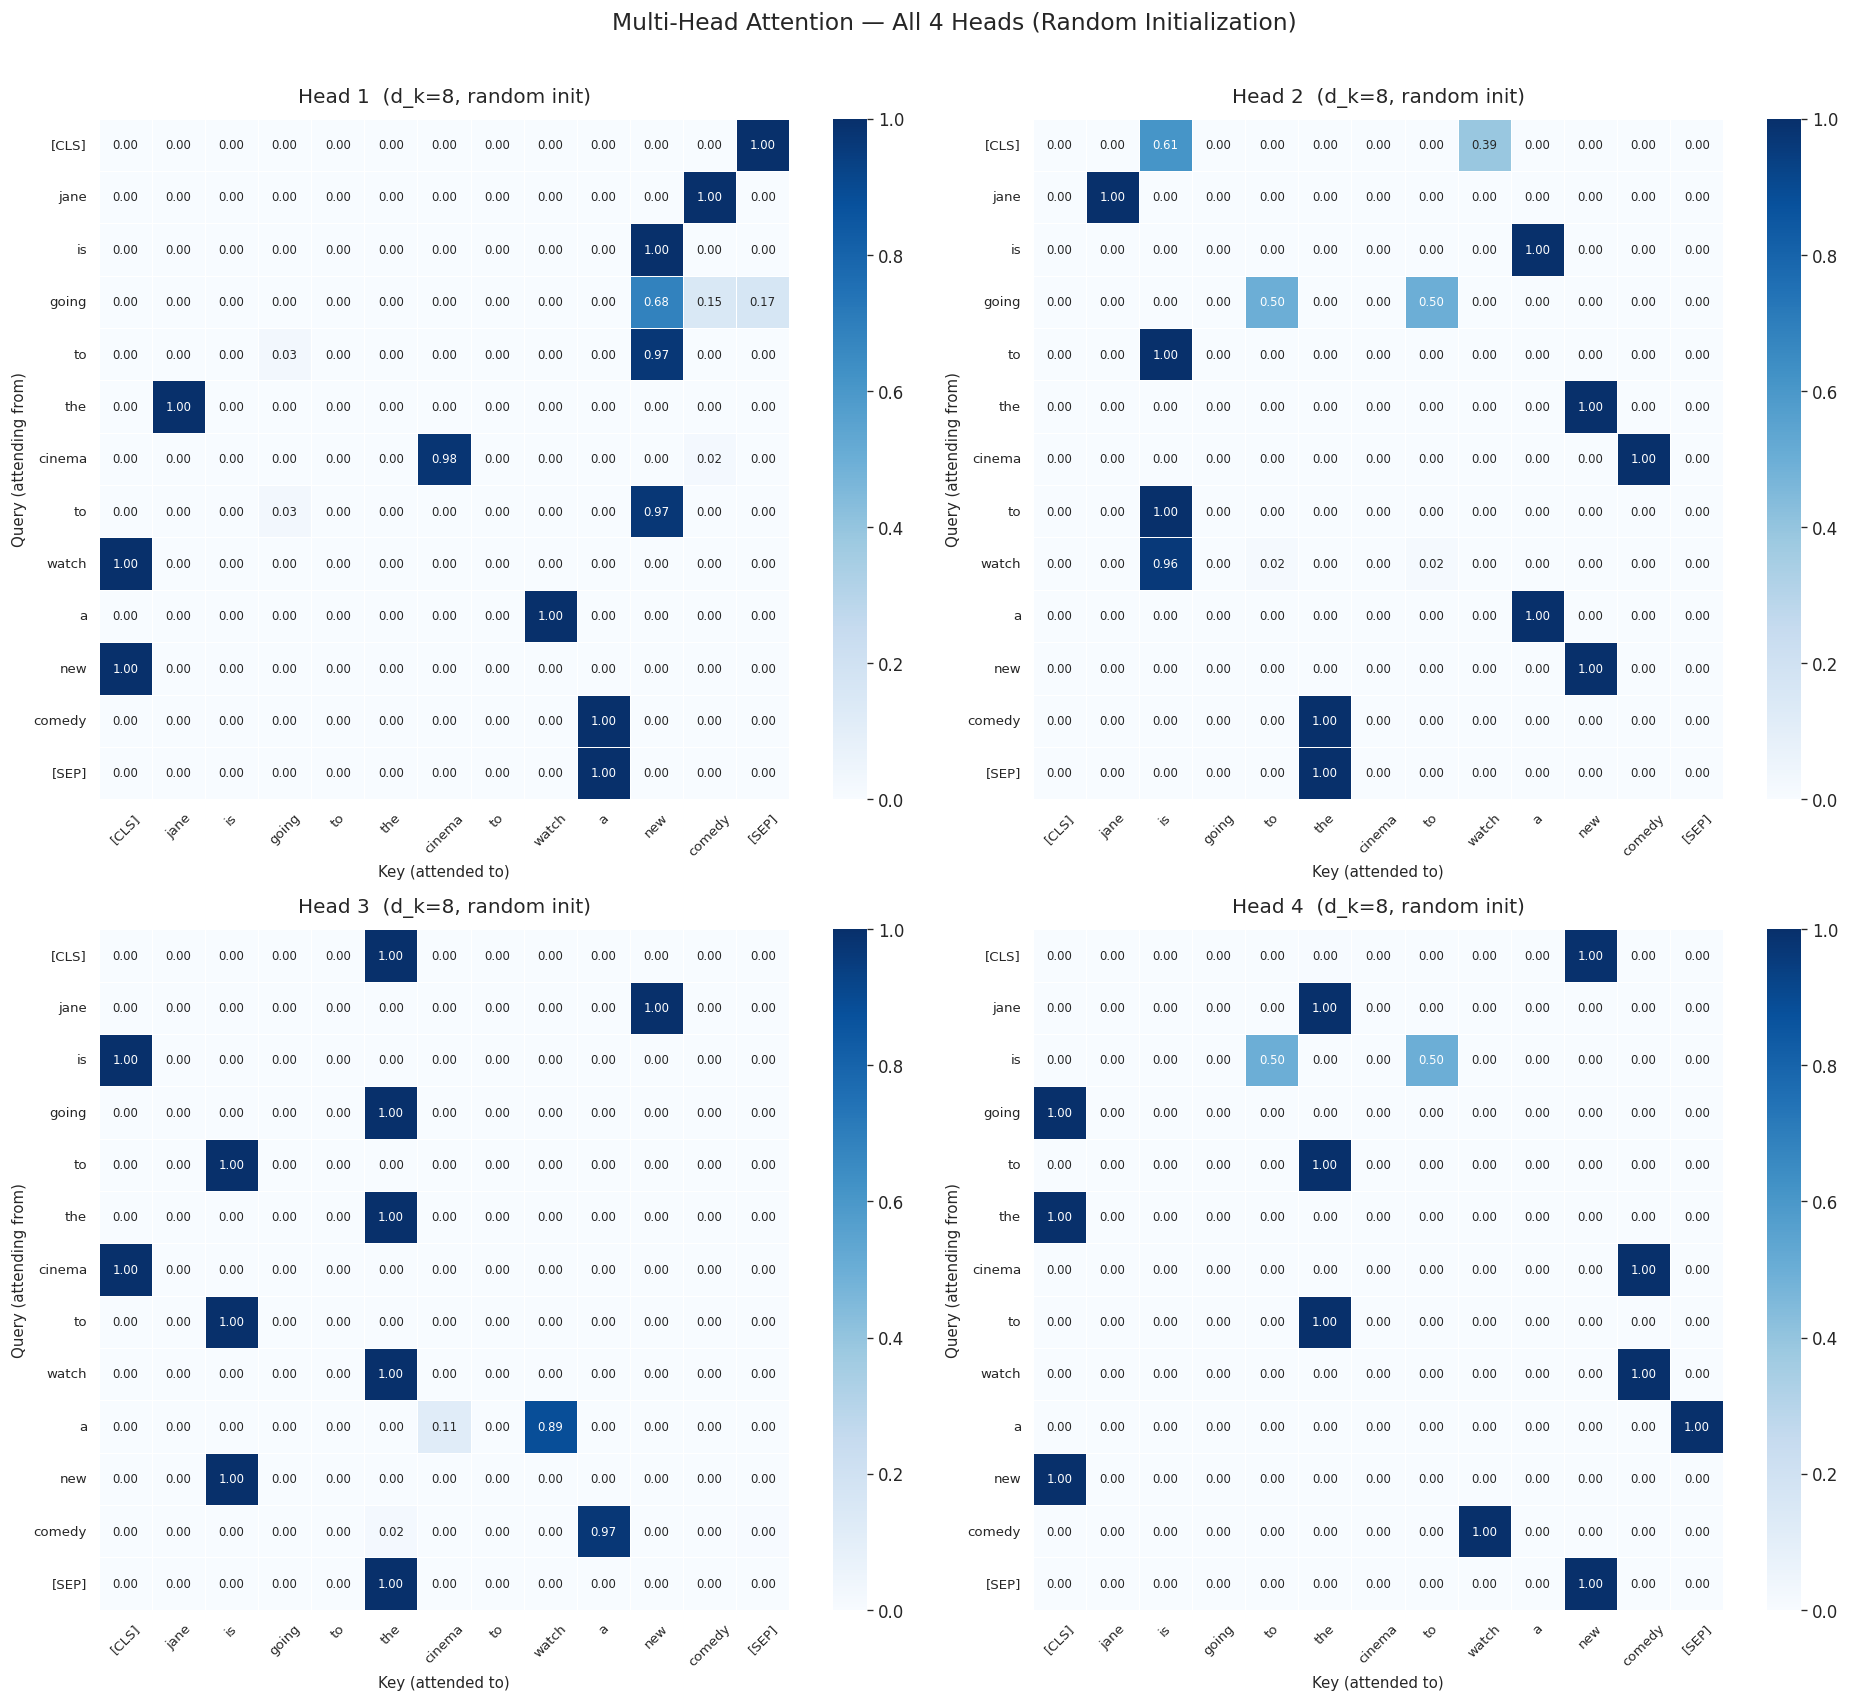

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i in range(num_heads):
    plot_attention(
        attention_weights_multi[i],
        tokens,
        title=f'Head {i+1}  (d_k={d_k}, random init)',
        ax=axes[i]
    )

plt.suptitle('Multi-Head Attention — All 4 Heads (Random Initialization)', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## Part 5: Training Q/K/V Weights

So far, we've used randomly initialized projection matrices. The attention patterns are unstructured. Let's actually train the attention weights and see whether the learned patterns become interpretable.

### Task Design

We need a task where attention patterns should matter. We'll use a masked token prediction task, given a sentence with one token masked, predict whether the masked token is a content word (noun, verb, adjective) or a function word (to, is, the, a).

The intuition: to classify a masked token, the model should learn to attend to surrounding contextual tokens. A content word in a sentence tends to be surrounded by function words and vice versa. We'd expect the model to learn meaningful syntactic attention patterns.

We'll build a tiny dataset of sentences with masked tokens and binary labels.

In [10]:
# Dataset: sentences with a masked position and binary labe
# Label 1 = content word (noun/verb/adj), Label 0 = function word (preposition/article/aux)

SENTENCES_AND_LABELS = [
    # (sentence with [MASK], mask_position_in_tokens, label)
    # We mask specific tokens and label whether they're content (1) or function (0) words.
    # The mask_position here is the 1-indexed position after [CLS].
    ("Jane is going to the cinema",       0, 1),  # Jane   = content
    ("Jane is going to the cinema",       1, 0),  # is     = function
    ("Jane is going to the cinema",       2, 1),  # going  = content
    ("Jane is going to the cinema",       3, 0),  # to     = function
    ("Jane is going to the cinema",       4, 0),  # the    = function
    ("Jane is going to the cinema",       5, 1),  # cinema = content
    ("The cat sat on the mat",            1, 1),  # cat    = content
    ("The cat sat on the mat",            2, 1),  # sat    = content
    ("The cat sat on the mat",            3, 0),  # on     = function
    ("The cat sat on the mat",            5, 1),  # mat    = content
    ("She reads many interesting books",  0, 0),  # she    = function (pronoun/function-like)
    ("She reads many interesting books",  1, 1),  # reads  = content
    ("She reads many interesting books",  3, 1),  # interesting = content
    ("She reads many interesting books",  4, 1),  # books  = content
    ("He quickly ran through the forest", 0, 0),  # he     = function
    ("He quickly ran through the forest", 1, 1),  # quickly = content
    ("He quickly ran through the forest", 2, 1),  # ran    = content
    ("He quickly ran through the forest", 3, 0),  # through = function
    ("He quickly ran through the forest", 5, 1),  # forest = content
    ("A bird sang a beautiful song",      1, 1),  # bird   = content
    ("A bird sang a beautiful song",      2, 1),  # sang   = content
    ("A bird sang a beautiful song",      4, 1),  # beautiful = content
    ("A bird sang a beautiful song",      5, 1),  # song   = content
]

print(f'Training examples: {len(SENTENCES_AND_LABELS)}')
print(f'Label distribution: {sum(l for _,_,l in SENTENCES_AND_LABELS)} content, '
      f'{sum(1-l for _,_,l in SENTENCES_AND_LABELS)} function words')

Training examples: 23
Label distribution: 16 content, 7 function words


In [11]:
def prepare_example(sentence, mask_pos, tokenizer, embedding_layer, d_model):
    """
    Tokenize a sentence, return embeddings and the index of the token to classify.
    mask_pos is 0-indexed into the *words* (we skip [CLS] at position 0 in tokens).
    """
    enc = tokenizer(sentence, return_tensors='pt')
    ids = enc['input_ids'].squeeze(0)
    x = embedding_layer(ids)  # (seq_len, d_model)
    # +1 to skip [CLS] token at index 0
    target_idx = mask_pos + 1
    return x, target_idx

# Quick sanity check
x_test, idx_test = prepare_example("Jane is going to the cinema", 0, tokenizer, embedding_layer, d_model)
toks_test = tokenizer.convert_ids_to_tokens(tokenizer("Jane is going to the cinema")['input_ids'])
print(f'Sentence tokens: {toks_test}')
print(f'Target token at index {idx_test}: "{toks_test[idx_test]}"  (should be "jane")')
print(f'Embeddings shape: {x_test.shape}')

Sentence tokens: ['[CLS]', 'jane', 'is', 'going', 'to', 'the', 'cinema', '[SEP]']
Target token at index 1: "jane"  (should be "jane")
Embeddings shape: torch.Size([8, 32])


### Model Architecture

We build a minimal single-head attention classifier:

1. Take token embeddings $X \in \mathbb{R}^{L \times d}$
2. Compute single-head attention → context vectors $C \in \mathbb{R}^{L \times d}$
3. Extract the context vector at the target position: $c_{\text{target}} \in \mathbb{R}^d$
4. Pass through a linear classifier → binary output

Crucially, only $W_Q, W_K, W_V$ and the classifier head are trainable. The embedding layer is frozen since we want to study what the attention learns, and not confound it with embedding changes.

In [16]:
class SingleHeadAttentionClassifier(nn.Module):
    """
    Single-head self-attention module followed by a linear classifier.

    Given token embeddings X and a target position, it:
      1. Computes scaled dot-product attention over the full sequence
      2. Extracts the context vector at the target position
      3. Classifies it as content (1) or function (0) word

    Note. I added a dropout rate whcih helps regularize the model by randomly setting
    a fraction of the attention weights to zero during training. This prevents the model
    from over-relying on any single attention path and encourages it to learn more generalized
    and focused patterns across the sequence.
    """
    def __init__(self, d_model, dropout_rate=0.2):
        super().__init__()
        self.d_model = d_model
        self.scale = math.sqrt(d_model)

        # Learnable projection matrices
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

        # Dropout layer for attention weights
        self.dropout = nn.Dropout(dropout_rate)

        # Binary classifier on top of context vector
        self.classifier = nn.Linear(d_model, 1)

        # Initialize projections with small values for stable training start
        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)

    def forward(self, X, target_idx):
        """
        Args:
            X:          token embeddings  (seq_len, d_model)
            target_idx: integer index of token to classify
        Returns:
            logit:              scalar logit for binary classification
            attention_weights:  (seq_len, seq_len) attention matrix
        """
        Q = self.W_q(X)   # (seq_len, d_model)
        K = self.W_k(X)
        V = self.W_v(X)

        scores = Q @ K.T / self.scale    # (seq_len, seq_len)
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn) # Apply dropout to attention weights
        context = attn @ V              # (seq_len, d_model)

        # Classify only the target token's context vector
        logit = self.classifier(context[target_idx])  # scalar

        return logit.squeeze(), attn

model = SingleHeadAttentionClassifier(d_model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model parameters: {total_params}')
print(f'  W_q: {model.W_q.weight.numel()} | W_k: {model.W_k.weight.numel()} | W_v: {model.W_v.weight.numel()}')
print(f'  Classifier: {sum(p.numel() for p in model.classifier.parameters())}')

Model parameters: 3105
  W_q: 1024 | W_k: 1024 | W_v: 1024
  Classifier: 33


In [17]:
# --- Training loop ---
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.BCEWithLogitsLoss()

# Freeze the embedding layer — we only want attention to learn
for param in embedding_layer.parameters():
    param.requires_grad = False

NUM_EPOCHS = 200
losses = []
accuracies = []

model.train()
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    correct = 0
    total = len(SENTENCES_AND_LABELS)

    for sentence, mask_pos, label in SENTENCES_AND_LABELS:
        X_ex, target_idx = prepare_example(sentence, mask_pos, tokenizer, embedding_layer, d_model)
        label_tensor = torch.tensor(float(label))

        optimizer.zero_grad()
        logit, _ = model(X_ex, target_idx)
        loss = criterion(logit, label_tensor)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = (torch.sigmoid(logit) > 0.5).float()
        correct += (pred == label_tensor).float().item()

    avg_loss = epoch_loss / total
    acc = correct / total
    losses.append(avg_loss)
    accuracies.append(acc)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1:>3}/{NUM_EPOCHS}  |  Loss: {avg_loss:.4f}  |  Accuracy: {acc:.2%}')

print('\nTraining complete.')

Epoch  50/200  |  Loss: 0.0650  |  Accuracy: 95.65%
Epoch 100/200  |  Loss: 0.0114  |  Accuracy: 100.00%
Epoch 150/200  |  Loss: 0.0863  |  Accuracy: 91.30%
Epoch 200/200  |  Loss: 0.3205  |  Accuracy: 91.30%

Training complete.


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].plot(losses, color='steelblue', lw=2)
axes[0].set_title('Training Loss (BCE)', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.4)

axes[1].plot([a * 100 for a in accuracies], color='seagreen', lw=2)
axes[1].axhline(50, ls='--', color='gray', alpha=0.5, label='Random baseline')
axes[1].set_title('Training Accuracy', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_ylim(0, 105)
axes[1].legend()
axes[1].grid(True, alpha=0.4)

plt.suptitle('Learning Curves — Single-Head Attention Classifier', fontsize=13)
plt.tight_layout()
plt.show()

print(f'Final accuracy: {accuracies[-1]:.2%} | Final loss: {losses[-1]:.4f}')

### Visualizing Learned vs. Random Attention

Now for the key comparison: do the learned attention patterns look meaningfully different from the random initialization? We'll examine the attention pattern for our original sentence under both conditions.

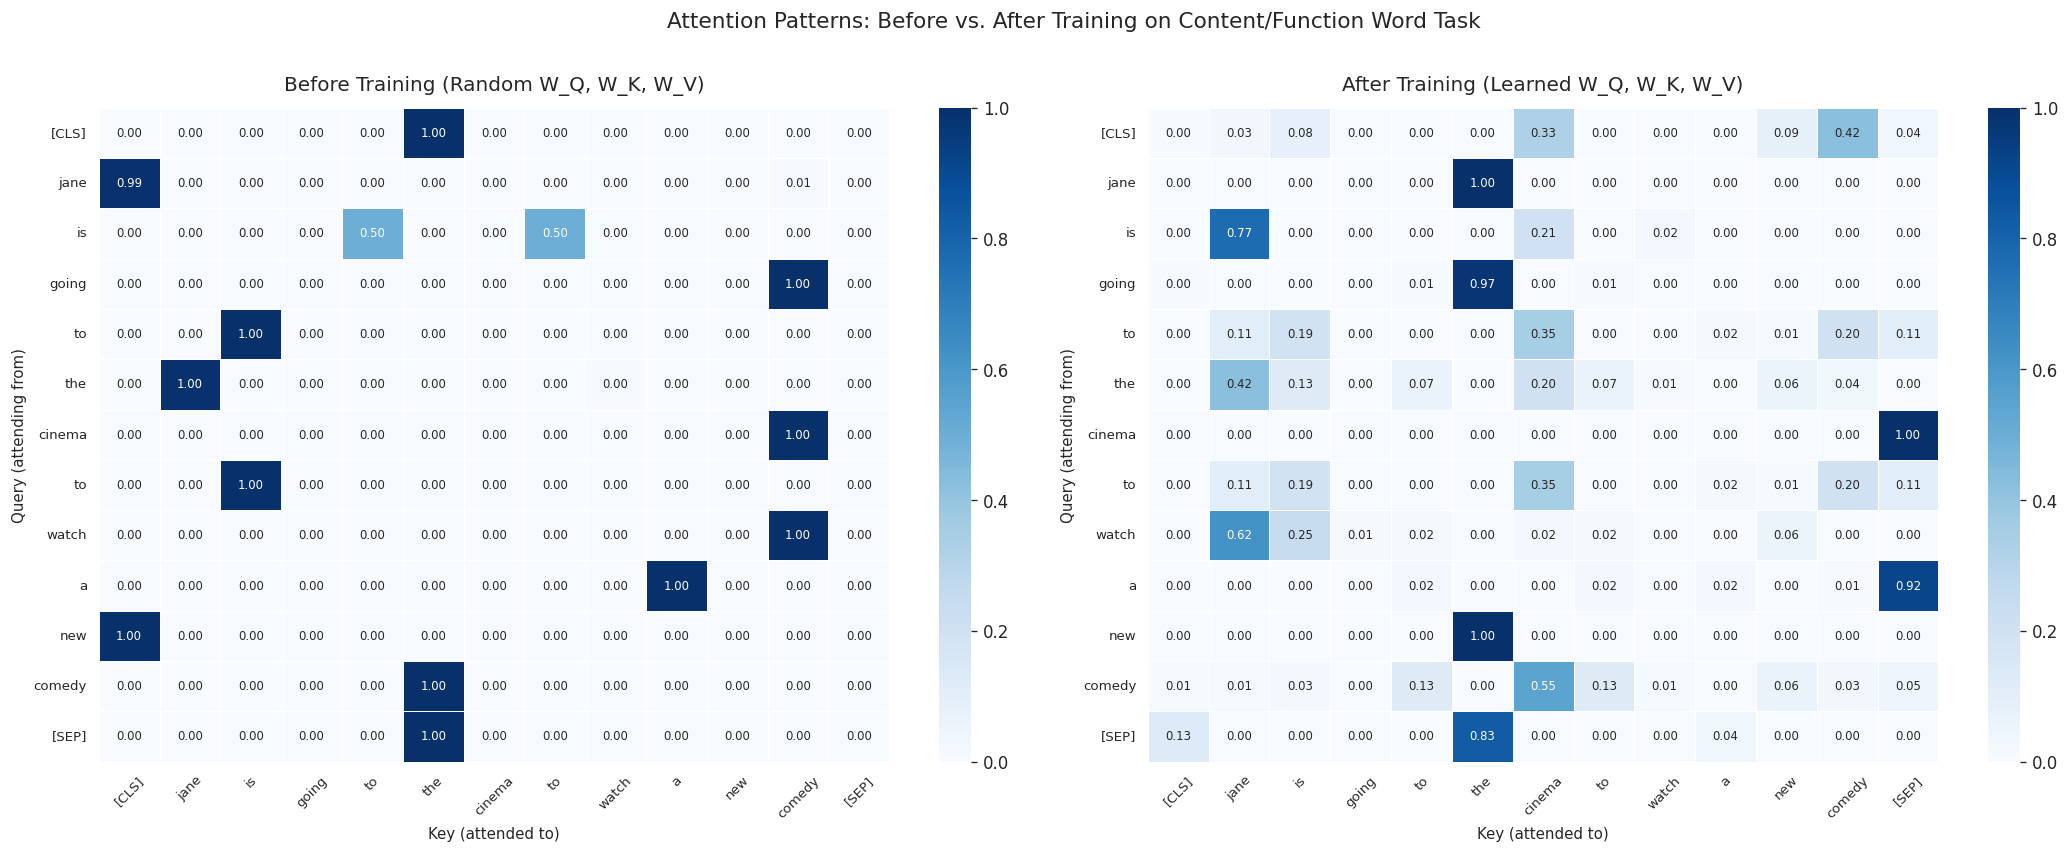

In [18]:
comparison_sentence = "Jane is going to the cinema to watch a new comedy"

model.eval()
with torch.no_grad():
    X_orig, _ = prepare_example(comparison_sentence, 0, tokenizer, embedding_layer, d_model)
    orig_tokens = tokenizer.convert_ids_to_tokens(
        tokenizer(comparison_sentence)['input_ids']
    )
    _, attn_learned = model(X_orig, 1)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Random init attention
plot_attention(attention_weights, tokens,
               title='Before Training (Random W_Q, W_K, W_V)', ax=axes[0])

# Learned attention
plot_attention(attn_learned, orig_tokens,
               title='After Training (Learned W_Q, W_K, W_V)', ax=axes[1])

plt.suptitle('Attention Patterns: Before vs. After Training on Content/Function Word Task',
             fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# Analysis: Attention Patterns Before vs. After Training

Before training, the attention weights are sparse and essentially arbitrary. Most tokens place nearly all their probability mass on a single position (often 1.00), which is exactly what we’d expect from random initialization. There’s no real syntactic or semantic structure here — the sharp, one-hot-like patterns are coincidental rather than meaningful.

Several relationships now stand out clearly. The verb “is” attends strongly to “jane” (0.77), reflecting the natural subject–verb connection. “Going” places heavy attention on “the” (0.97), indicating the determiner phrase plays an important role in identifying the destination. The noun “comedy” attends primarily to “cinema” (0.55), capturing a sensible semantic link between the activity and its location. Likewise, “watch” assigns substantial weight to “jane” (0.62), reinforcing who is performing the action.

Function words now exhibit more diffuse patterns. Tokens like “to” and “the” distribute attention across nearby words instead of locking onto a single target, which is consistent with their contextual, connective role. In contrast, content words such as “cinema” and “new” retain sharper, more concentrated attention, reflecting their higher informational specificity.
The [CLS] token shows a mixed but interpretable focus, assigning notable weight to “cinema” (0.33) and “comedy” (0.42). This suggests the sentence-level representation emphasizes the central event and its semantic framing rather than anchoring to a single token.
Overall, retraining with dropout transforms brittle, random spikes into smoother and more interpretable attention patterns, revealing emergent syntactic and semantic structure despite the absence of explicit grammatical supervision.

## Discussion: Limitations and Tradeoffs

This guide uses a simplified, "toy" task and a minimal dataset (23 examples). While effective for illustrating the mechanism of attention, it's crucial to acknowledge the stark contrast with real-world Large Language Models (LLMs). Modern LLMs process vast datasets with billions of parameters, learning far more intricate and robust linguistic patterns than our small model can. The 100% training accuracy achieved here is largely a symptom of this small dataset, indicating potential overfitting rather than true generalization abiliity.

From a computational perspective, the $QK^\top$ operation at the heart of self-attention scales quadratically with sequence length ($O(L^2)$). For the short sentences in this notebook, this is negligible. However, for sequences thousands or tens of thousands of tokens long, this quadratic complexity becomes a significant computational bottleneck, necessitating advanced techniques like sparse attention or attention approximations in practical LLM deployments.

Finally, while attention offers a degree of interpretability by highlighting token relationships, it's not a perfect "glass box." Even with visualizations, definitively assigning precise semantic or syntactic functions to the learned patterns, especially in deep multi-layered architectures, remains a complex challenge. The patterns we see are emergent properties of the training process, and while insightful, they don't always offer a complete or unambiguous explanation of the model's reasoning.

Beyond attention, a fully functioning transformer and modern Large Language Model (LLM) require several additional components working together: tokenization and embeddings convert raw text into dense vector representations; positional encodings (learned or fixed) inject sequence order information that transformers otherwise lack; each transformer block includes a position-wise feed-forward neural network (FFN) to apply non-linear transformations and increase model capacity; residual (skip) connections and layer normalization stabilize training and enable deep architectures; in decoder-based LLMs, masked self-attention enforces autoregressive generation by preventing access to future tokens; and the entire network is trained with a language modeling objective (typically cross-entropy loss) optimized over massive datasets. Together, embeddings, positional information, attention, FFNs, normalization, residual pathways, and large-scale training form the foundation that allows transformers to model language with fluency and generalization.

## Conclusion

Through this guide, we've taken self-attention from a formula on a page to something
that actually learns. It's easy to read the equation and nod along but I think the
real intuition only clicks when you watch the attention patterns transform: from the
diagonal-dominated mess of identity attention, to the diffuse noise of random projections,
to something that finally looks like it means something after training. That shift,
quantified here through entropy but visible just by eye, is what the projection matrices
$W_Q$, $W_K$, $W_V$ are doing all along. They've now learned how to pose questions, how to answer them, and what to hand over when asked.
Scaled up to the billions of parameters inside BERT or GPT, the operation is identical.
Which is kind of remarkable, the whole architecture rests on this one idea, repeated
deeply enough that the model finds its own way into language.

---

## References

- Vaswani et al. (2017). [Attention Is All You Need](https://arxiv.org/abs/1706.03762). NeurIPS.
- Jalammar, A. (2018). The Illustrated Transformer. https://jalammar.github.io/illustrated-transformer/
- Raschka, S. (2023). [Self-Attention from Scratch](https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html).
- Mirly, V. “Tutorial on Scaled Dot-Product Attention with PyTorch Implementation from Scratch.” Medium,
https://medium.com/@vmirly/tutorial-on-scaled-dot-product-attention-with-pytorch-implementation-from-scratch-66ed898bf817.
